In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm

In [2]:
pop_df=pd.read_csv(r'C:\Users\Yasaman\Downloads\World_bank_population.csv',skiprows=3)
pop_df['Country Code']=pop_df['Country Code'].apply(lambda x: x.lower())
possible_countries=pop_df.query(" `2019` >=1000000")['Country Code'].values

excluded_iso3_codes = [
    "IRL",  # Ireland
    "SSD",  # South Sudan
    "SDN",  # Sudan
    "COG",  # Republic of the Congo
    "COD",  # Democratic Republic of the Congo
    "GIN",  # Guinea
    "GNB",  # Guinea-Bissau
    "GNQ",  # Equatorial Guinea
    "PNG",  # Papua New Guinea
    "XKX",  # Kosovo (unofficial)
    "MNE",  # Montenegro
    "SRB",  # Serbia
    "TLS",   # Timor-Leste
    "GEO", #Georgia
    'SWZ', 
    'PRK', #North Korea
]
excluded_iso3_codes=[c.lower() for c in excluded_iso3_codes]


possible_iso=list(set(possible_countries)-set(excluded_iso3_codes))
df = pd.read_csv(r"C:\Users\Yasaman\Downloads\Attention-fractional counting.csv")
df.rename(columns={'aggregated_value': 'count', 'country': 'Mention_country', 'affiliation_country': 'Aff_country'}, inplace=True)
df=df[(df['Mention_country'].isin(possible_iso))&(df['Aff_country'].isin(possible_iso))]
df = df[df['year'].isin(np.arange(2002, 2020))]
Country_list={'Egypt':'EGY', 'Tunisia':'TUN','Libya':'LBY','Syria':'SYR','Yemen':'YEM','Bahrain':'BHR','Jordan':'JOR','Kuwait':'KWT','Morocco':'MAR','Oman':'OMN'}
rev_Country_list={Country_list[key]: key for key in Country_list}
abbr=[country.lower() for country in Country_list.values()]
physical_sciences=['MATH', 'ENGI', 'PHYS', 'COMP', 'MUL']
df=df[~df['subjarea'].isin(physical_sciences)]
df=df.groupby(['year', 'Mention_country'])['count'].sum().reset_index()


data=pd.read_csv(r"C:\Users\Yasaman\Downloads\scopus_2024_V1_scholarlymigration_country_enriched.csv")
data=data[data['year'].isin(np.arange(2002, 2020))]
data=data[['iso3code', 'incomelevel', 'gdp_per_capita', 'year', 'population', 'region', 'padded_population_of_researchers']].dropna()
data.rename(columns={'iso3code':'Mention_country'}, inplace=True)
data['Mention_country']=data['Mention_country'].apply(lambda x: x.lower())
df=df.merge(data, on=['Mention_country', 'year'], how='outer')
df=df[df['Mention_country'].isin(possible_iso)]


countries_to_remove=[]
for c  in df['Mention_country'].unique():
    if ((~df['count'].isna()) & (df['Mention_country'] == c)).sum()<15:
        countries_to_remove.append(c)
        print(c)

print(len(countries_to_remove))


# Define the required year range
required_years = list(range(2002, 2020))

# Get the unique countries
unique_countries = df["Mention_country"].unique()

# Create a complete DataFrame with all country-year combinations
full_data = []
for country in unique_countries:
    country_data = df[df["Mention_country"] == country]
    existing_years = set(country_data["year"])
    
    for year in required_years:
        if year in existing_years:
            row = country_data[country_data["year"] == year].iloc[0].to_dict()
        else:
            row = {
                "year": year,
                "Mention_country": country,
                "count": 0,
                "gdp_per_capita": np.nan,
                "population": np.nan,
                "region": country_data["region"].iloc[0] if not country_data.empty else np.nan,
            }
        full_data.append(row)

# Convert to DataFrame
df_complete = pd.DataFrame(full_data)

df_complete['treated']=df_complete['Mention_country'].isin(abbr).astype(int)
df_complete['treated_CW']=df_complete['Mention_country'].isin(['yem', 'lby', 'syr']).astype(int)
df_complete['treated_GO']=df_complete['Mention_country'].isin(['egy', 'tun']).astype(int)
df_complete['treated_GC']=df_complete['Mention_country'].isin(['omn', 'kwt', 'bhr', 'mar','jor']).astype(int)
df_complete['post']=df_complete['year'].apply(lambda x: 0 if x>=2002 and x<=2010 else 1 )
df_complete['count']=df_complete['count'].fillna(0)
df_complete['log_count']=np.log(df_complete['count']+1)

df_complete[['region', 'gdp_per_capita', 'population','padded_population_of_researchers']] = df_complete.groupby('Mention_country')[[ 'region', 'gdp_per_capita', 'population','padded_population_of_researchers']].ffill()
df_complete[[ 'region', 'gdp_per_capita', 'population','padded_population_of_researchers']] = df_complete.groupby('Mention_country')[[ 'region', 'gdp_per_capita', 'population','padded_population_of_researchers']].bfill()
df_complete['log_gdp']=np.log(df_complete['gdp_per_capita'])
df_complete['log_population']=np.log(df_complete['population'])
df_complete['log_Rpop']=np.log(df_complete['padded_population_of_researchers']+1)
df_complete=df_complete[df_complete['Mention_country'].isin(possible_iso)].reset_index(drop=True)

0


In [3]:
def compute_pretrend_slopes(df, outcome="log_count"):
    results = []
    for country, dfg in df[df["post"] == 0].groupby("Mention_country"):
        if dfg["year"].nunique() > 1:  # need at least 2 years
            X = sm.add_constant(dfg["year"])
            y = dfg[outcome]
            model = sm.OLS(y, X).fit()
            slope = model.params["year"]
        else:
            slope = None  # not enough years to estimate
        results.append({"country": country, "pretrend_slope": slope})
    return pd.DataFrame(results)

slopes_df = compute_pretrend_slopes(df_complete[df_complete["post"] == 0], outcome="log_count")
df_complete=pd.merge(df_complete, slopes_df, left_on="Mention_country", right_on="country", how="left").drop("country", axis=1)


In [5]:
pre_summ=df_complete.query(" `year`< 2011 ").groupby('Mention_country')[['treated', 'log_count', 'log_gdp', 'log_population', 'log_Rpop', 'pretrend_slope']].mean().reset_index()
def zscore_to_bins(s, edges):
    z = (s - s.mean())/s.std(ddof=0)  
    return pd.cut(z, bins=edges, include_lowest=True)

E5 =  [-np.inf, -1.5, -0.75, 0.75, 1.5, np.inf]

pre_summ['log_count_bin'] = zscore_to_bins(pre_summ['log_count'], E5)
pre_summ['log_gdp_bin'] = zscore_to_bins(pre_summ['log_gdp'], E5)
pre_summ['log_population_bin'] = zscore_to_bins(pre_summ['log_population'], E5)
pre_summ['log_Rpop_bin'] = zscore_to_bins(pre_summ['log_Rpop'], E5)
pre_summ['pretrend_slope_bin'] = zscore_to_bins(pre_summ['pretrend_slope'], E5)


strata_cols = ['log_count_bin', 'log_gdp_bin', 'log_population_bin', 'log_Rpop_bin', 'pretrend_slope_bin']
pre_summ['stratum'] = pre_summ[strata_cols].astype(str).agg('|'.join, axis=1)


pre_summ=pre_summ.reset_index().rename(columns={'index':'id'}    )
# CEM pruning + weights
counts = pre_summ.groupby(['stratum','treated'])['id'].count().unstack(fill_value=0)
valid_strata = counts[(counts[0] > 0) & (counts[1] > 0)].index
matched = pre_summ[pre_summ['stratum'].isin(valid_strata)].copy()


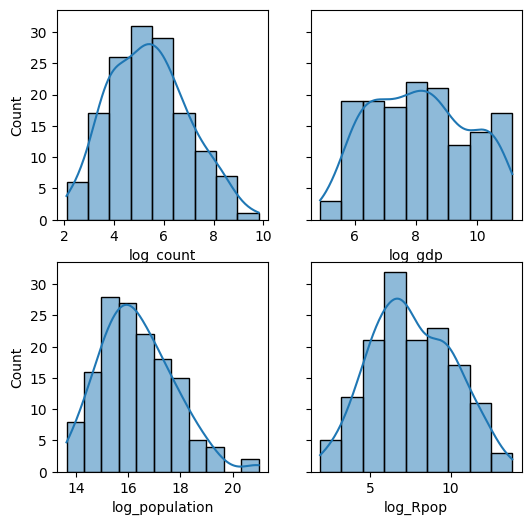

<Axes: xlabel='pretrend_slope', ylabel='Count'>

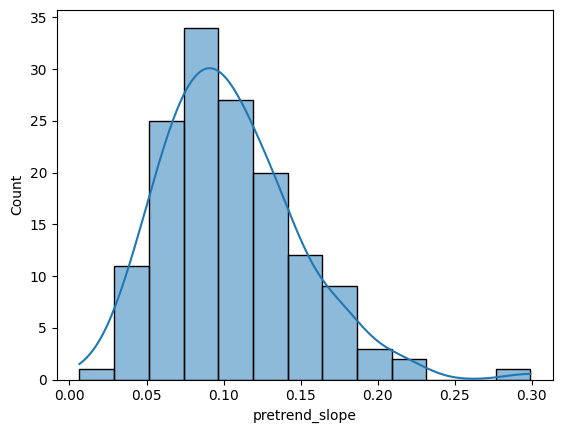

In [11]:
fig, ax=plt.subplots(nrows=2, ncols=2, figsize=(6, 6), sharey=True)
ax=ax.flat
sns.histplot(pre_summ['log_count'], kde=True, ax=ax[0])
sns.histplot(pre_summ['log_gdp'], kde=True, ax=ax[1])
sns.histplot(pre_summ['log_population'], kde=True, ax=ax[2] )
sns.histplot(pre_summ['log_Rpop'], kde=True,ax=ax[3] )
plt.show()
sns.histplot(pre_summ['pretrend_slope'], kde=True)

In [13]:
matched[matched['treated']==0].Mention_country.unique()

array(['bgr', 'bol', 'cmr', 'cri', 'cub', 'dza', 'ecu', 'irq', 'kaz',
       'lbn', 'lka', 'mys', 'ner', 'per', 'pri', 'rou', 'sen', 'svn',
       'tgo', 'tto', 'ukr', 'ven'], dtype=object)

In [7]:
# table of counts by stratum and treated
tab = (matched
       .groupby(['stratum','treated'])['id']
       .size()
       .unstack(fill_value=0)
       .rename(columns={0:'n_control', 1:'n_treated'}))

# join back by stratum
matched = matched.join(tab, on='stratum')

matched['cem_w'] = np.where(
    matched['treated'] == 1,
    1.0,
    matched['n_treated'] / matched['n_control']
)


In [9]:
matched.to_csv(r'C:\Users\Yasaman\Arab Spring Paper\Arab Spring Code\DiD analysis with matching\Attention\Total attention\matched_data.csv', index=False)